Ratings Sample:
    userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931
Movies Sample:
    movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  
Tags Sample:
    userId  movieId              tag   timestamp
0       2    60756            funny  1445714994
1       2    60756  Highly quotabl

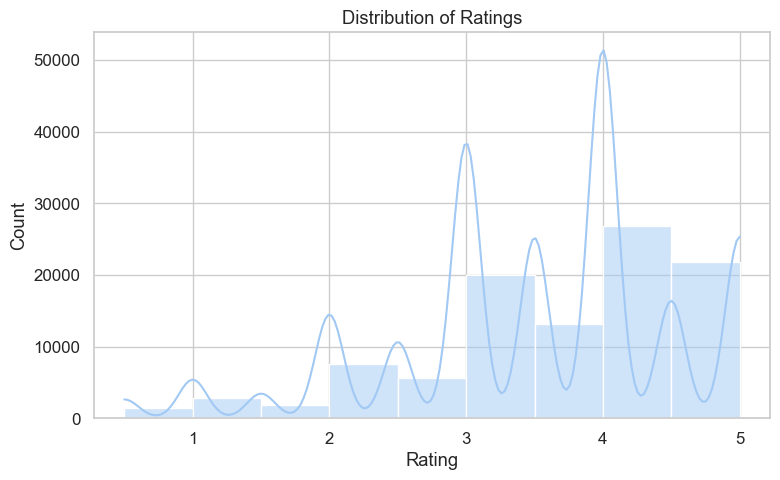

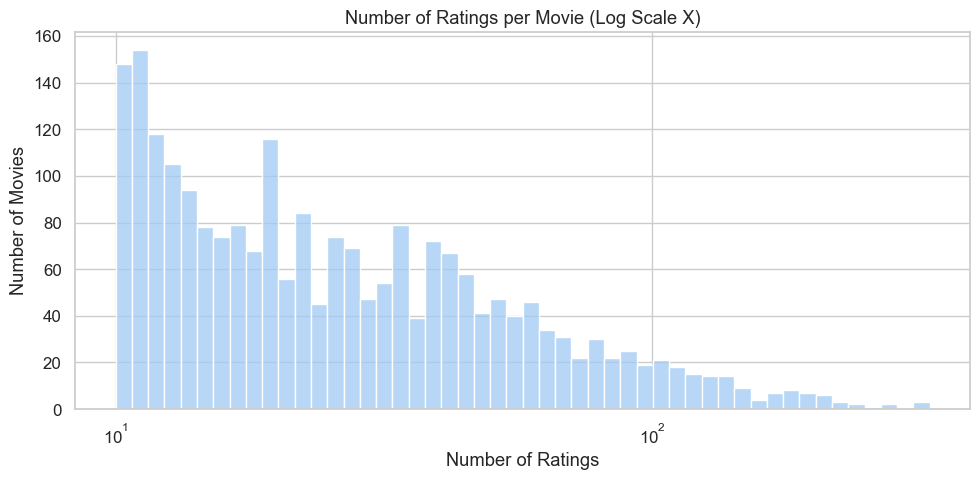

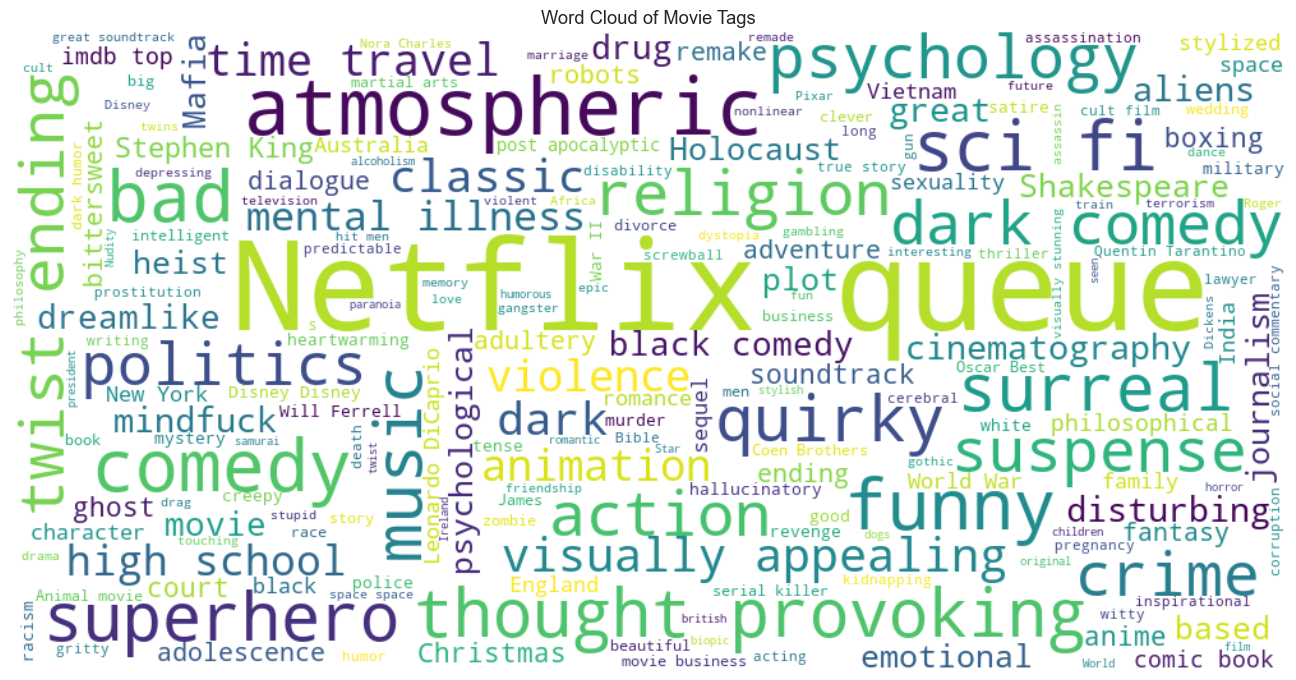

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 886, cost: 14797.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 970, cost: 14127.0
Run 2, iteration: 2/100, moves: 91, cost: 14127.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 442, cost: 14674.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 187, cost: 15600.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 1949, cost: 13401.0
Best run was number 5
Number of movies per cluster:
 Cluster
0    3714
1    3295
2     931
3     790
4    1012
Name: count, dtype: int64

Sample movies from Cluster 0:

0                          Toy Story (1995)
1                            Jumanji (1995)
2                   Grumpier Old Men 

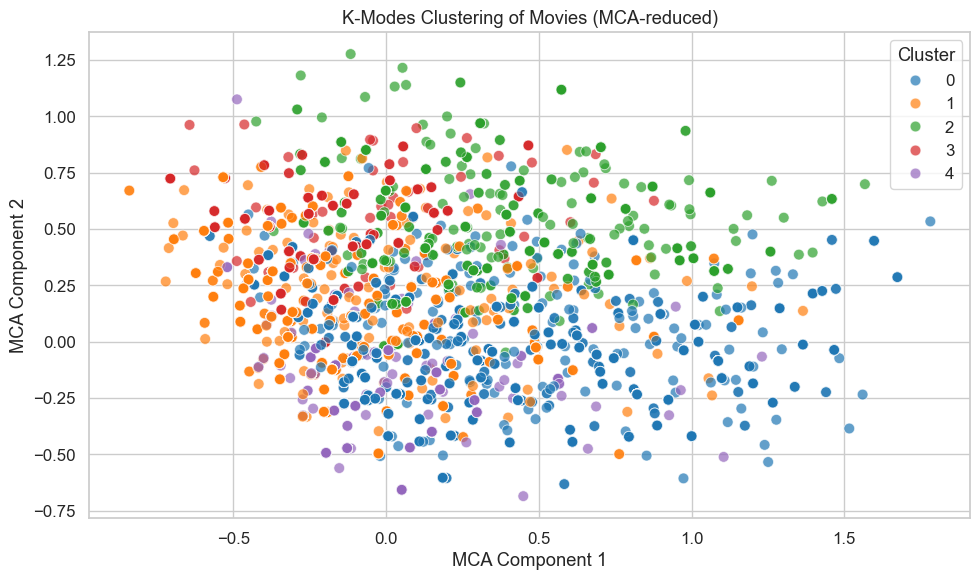

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

sns.set(style='whitegrid', palette='pastel', font_scale=1.1)

# Load the CSV datasets
ratings = pd.read_csv('ratings.csv')
movies = pd.read_csv('movies.csv')
tags = pd.read_csv('tags.csv')
links = pd.read_csv('links.csv')

print("Ratings Sample:\n", ratings.head())
print("Movies Sample:\n", movies.head())
print("Tags Sample:\n", tags.head())
print("Links Sample:\n", links.head())

ratings['timestamp'] = pd.to_datetime(ratings['timestamp'], unit='s')
tags['timestamp'] = pd.to_datetime(tags['timestamp'], unit='s')


print("\nMissing Values Summary:")
print(ratings.isnull().sum())
print(movies.isnull().sum())
print(tags.isnull().sum())
print(links.isnull().sum())

tags.drop_duplicates(inplace=True)

ratings_movies = pd.merge(ratings, movies, on='movieId')

print("\nRatings Summary:")
print(ratings['rating'].describe())

print(f"\nNumber of unique users: {ratings['userId'].nunique()}")
print(f"Number of unique movies: {ratings['movieId'].nunique()}")

top_rated = ratings_movies['title'].value_counts().head(10)
print("\nTop 10 Most Rated Movies:\n", top_rated)

plt.figure(figsize=(8, 5))
sns.histplot(ratings['rating'], bins=9, kde=True)
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

ratings_per_movie = ratings['movieId'].value_counts()
filtered = ratings_per_movie[ratings_per_movie >= 10]
plt.figure(figsize=(10, 5))
sns.histplot(filtered, bins=50, log_scale=True)
plt.title('Number of Ratings per Movie (Log Scale X)')
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Movies')
plt.tight_layout()
plt.show()

# Word Cloud from Tags
text = ' '.join(tags['tag'].dropna().astype(str).values)
wordcloud = WordCloud(width=1000, height=500, background_color='white', colormap='viridis').generate(text)
plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Movie Tags')
plt.tight_layout()
plt.show()

# Install kmodes if not already installed
!pip install kmodes

# Import necessary library for K-Modes clustering
from kmodes.kmodes import KModes
# Expand genres into individual rows per movie
movies_expanded = movies.copy()
movies_expanded['genres'] = movies_expanded['genres'].str.split('|')
movies_expanded = movies_expanded.explode('genres')

# Create one-hot encoded genre columns using crosstab (more reliable than pivot_table here)
genre_ohe = pd.crosstab(movies_expanded['movieId'], movies_expanded['genres'])

# Reset index to bring 'movieId' back as a column
genre_ohe.reset_index(inplace=True)

# Merge one-hot genre data with movie titles
movies_with_titles = pd.merge(movies[['movieId', 'title']], genre_ohe, on='movieId')

# Prepare the features for K-Modes clustering (exclude ID and title)
X = movies_with_titles.drop(columns=['movieId', 'title'])

# Apply K-Modes clustering
from kmodes.kmodes import KModes

km = KModes(n_clusters=5, init='Huang', n_init=5, verbose=1)
clusters = km.fit_predict(X)

# Assign clusters back to the main DataFrame
movies_with_titles['Cluster'] = clusters

# View cluster distribution
print("Number of movies per cluster:\n", movies_with_titles['Cluster'].value_counts().sort_index())

# Preview titles per cluster
for i in range(5):
    print(f"\nSample movies from Cluster {i}:\n")
    print(movies_with_titles[movies_with_titles['Cluster'] == i]['title'].head(10))


# Install the MCA package (prince)
!pip install prince

# Import MCA from prince
import prince
import matplotlib.pyplot as plt
import seaborn as sns


# STEP 6: Visualize Clusters using MCA


# Re-apply MCA to the feature space (X)
# NOTE: X is one-hot encoded genre data
mca = prince.MCA(n_components=2, random_state=42)
mca_coords = mca.fit_transform(X)

# Add MCA components and cluster labels to a new DataFrame
mca_df = mca_coords.copy()
mca_df['Cluster'] = movies_with_titles['Cluster']

# Plot clusters in 2D MCA space
plt.figure(figsize=(10, 6))
sns.scatterplot(data=mca_df, x=0, y=1, hue='Cluster', palette='tab10', s=60, alpha=0.7)
plt.title('K-Modes Clustering of Movies (MCA-reduced)')
plt.xlabel('MCA Component 1')
plt.ylabel('MCA Component 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.tight_layout()
plt.show()
